In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import train_test_split

In [4]:
#Reading in the data
data = pd.read_csv('C:\\Users\\19258\\Downloads\\house-prices-advanced-regression-techniques\\train.csv')
test = pd.read_csv('C:\\Users\\19258\\Downloads\\house-prices-advanced-regression-techniques\\test.csv')

#Adjusting test and training data before combining them
test_id = test['Id']
data = data[data['GrLivArea'] < 4500]
data.drop(['Id'], axis = 1, inplace = True)
test.drop(['Id'], axis = 1, inplace = True)

#Normalizing the Target
data['SalePrice'] = np.log1p(data['SalePrice'])
#Removing rows that are missing the target value
data.dropna(axis = 0, subset = ['SalePrice'], inplace = True)
#Setting the target to the Sale Price so that it can be dropped from the training set
target = data.SalePrice
#data.drop(['SalePrice'], axis = 1, inplace = True)

#Combining the data
combine = pd.concat([data, test], sort = False)

#plt.figure(figsize = [21,14])
#sns.heatmap(data.corr(), annot = True, fmt = '.2f', cmap = 'RdBu')

In [5]:
#Finding all the String columns with missing values
combine.select_dtypes(include = 'object').isnull().sum()[combine.select_dtypes(include = 'object').isnull().sum()>0]
#Some missing values should be corrected to not available, and some to mode, determine this through inspection
#Changing the columns that should be null

for col in ('Alley','Utilities','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
           'BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC',
           'Fence','MiscFeature'):
    combine[col] = combine[col].fillna('None')
        
#Changing columns that should be mode
for col in ('MSZoning','Electrical','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional'):
    combine[col] = combine[col].fillna(combine[col].mode()[0])

#Finding all numerical columns with missing values
combine.select_dtypes(exclude = 'object').isnull().sum()[combine.select_dtypes(exclude = 'object').isnull().sum()>0]

#Some missing values should be not available, and some should be mean, determine this through inspection
for col in ('MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath',
           'GarageYrBlt','GarageCars','GarageArea'):
    combine[col] = combine[col].fillna(0)

#Adding in new features
combine['HasPool'] = combine['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
combine['Has2ndFlr'] = combine['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
combine['HasGarage'] = combine['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
combine['HasFirePlace'] = combine['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

combine['LotFrontage'] = combine['LotFrontage'].fillna(combine['LotFrontage'].mean())

combine.drop(['GarageCars','TotRmsAbvGrd','GarageYrBlt'], axis = 1, inplace = True)

In [5]:
#Normalizing features with large skews
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in combine.columns:
    if combine[i].dtype in numeric_dtypes:
        numerics2.append(i)
        
skew_features = combine[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    combine[i] = boxcox1p(combine[i], boxcox_normmax(combine[i] + 1))

In [6]:
#Cleaning up the data
data_one = combine.iloc[:data.shape[0], :]
test_one = combine.iloc[data.shape[0]:, :]
#Splitting up the data for cross validation
X_train, X_valid, y_train, y_valid = train_test_split(data_one, target, train_size = 0.8, test_size = 0.2, random_state = 0)

#Using one hot encoding for categorical columns
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
test_one = pd.get_dummies(test_one)

#Realigning the column index names
X_train, X_valid = X_train.align(X_valid, join = 'left', axis = 1)
X_train, test_one = X_train.align(test_one, join = 'left', axis = 1)

#Filling in NaN values
X_valid.fillna(0)
for col in ('Utilities_NoSeWa','Condition2_RRAn','Condition2_RRNn','HouseStyle_2.5Fin','RoofMatl_Membran',
           'RoofMatl_Metal','RoofMatl_Roll','Exterior1st_Stone','Exterior2nd_Other','Heating_Floor','Heating_OthW',
           'Electrical_Mix','GarageQual_Ex','PoolQC_Fa'):
    test_one[col] = test_one[col].fillna(0)
  

for col in ('Utilities_NoSeWa','Neighborhood_NPkVill','Condition1_RRNe','Condition2_PosA','Condition2_PosN',
           'Condition2_RRAn','RoofStyle_Gambrel','RoofMatl_Membran','RoofMatl_Metal','RoofMatl_Roll',
            'RoofMatl_WdShake','Exterior1st_AsphShn','Exterior1st_BrkComm','Exterior1st_CBlock','Exterior1st_Stone',
           'Exterior2nd_Brk Cmn','Exterior2nd_CBlock','Exterior2nd_Other','ExterCond_Po','Foundation_Stone',
           'BsmtCond_Po','Heating_Floor','Heating_Grav','Heating_OthW','HeatingQC_Po','Electrical_Mix',
            'Functional_Maj2','Functional_Sev','GarageType_2Types','GarageQual_Po','GarageCond_Po','PoolQC_Ex',
           'MiscFeature_Othr','SaleType_Oth'):
    X_valid[col] = X_valid[col].fillna(0)


In [380]:
X_valid.isnull().any()[X_valid.isnull().any() > 0]

Series([], dtype: bool)

In [2]:
#Using XGBoost model to predict house price
import xgboost as xgb
from xgboost import XGBRegressor
prediction_model = XGBRegressor(n_estimators = 1000, learning_rate = 0.05)
prediction_model.fit(X_train, y_train, early_stopping_rounds = 20, 
                     eval_set = [(X_valid, y_valid)], verbose = 'False')

NameError: name 'X_train' is not defined

In [438]:
#Trying Ridge Regression
#alpha_list = [14.5, 14.6, 14.7, 14.8, 14.9, 15.0, 15.1, 15.2, 15.3, 15.4, 15.5]
from sklearn.linear_model import Ridge
prediction_model = Ridge(alpha = 12.5)
prediction_model.fit(X_train, y_train)
predictions = prediction_model.predict(X_valid)

In [469]:
#Blending models
def blend_models_prediction(x,y,z,g,h):
    predict_one = Ridge(alpha = 12.5)
    predict_one.fit(x,y)
    a = predict_one.predict(z)
    c = predict_one.predict(g)
    predict_two = XGBRegressor(n_estimators = 1000, learning_rate = 0.05)
    predict_two.fit(X_train, y_train, early_stopping_rounds = 20, 
                     eval_set = [(X_valid, y_valid)], verbose = 'False')
    b = predict_two.predict(z)
    d = predict_two.predict(g)
    
    prediction = 0.75*c + 0.25*d
    print("Mean absolute error:", mean_absolute_error(prediction, h))
    print("Mean squared error:", mean_squared_error(prediction, h))
    return ((0.75*a + 0.25*b))

In [427]:
#Checking how accurate the model is by using mean absolute error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
mae = mean_absolute_error(predictions, y_valid)
mse = mean_squared_error(predictions, y_valid)
print(" Mean absolute error:", mae, '\n', "Mean squared error:", mse)

 Mean absolute error: 0.0733764784386315 
 Mean squared error: 0.010255009441332164


In [470]:
#Running the model on the test file and turning it into a submission
test_predictions = np.expm1(blend_models_prediction(X_train, y_train, test_one, X_valid, y_valid)) 
submission = pd.DataFrame({'Id':test_id, 'SalePrice': test_predictions})
submission.to_csv('HousePricePrediction.csv', index = False)

C:\Users\19258\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:34:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Will train until validation_0-rmse hasn't improved in 20 rounds.
Stopping. Best iteration:
[443]	validation_0-rmse:0.105293

Mean absolute error: 0.07239371134415788
Mean squared error: 0.009771977928546416


In [471]:
submission

,Id,SalePrice
0,1461,121330.517221
1,1462,161156.763694
2,1463,186909.494059
3,1464,199167.732694
4,1465,191762.294617
5,1466,173017.238554
6,1467,175661.326210
7,1468,159913.087647
8,1469,193223.500606
9,1470,118313.427449


Series([], dtype: bool)

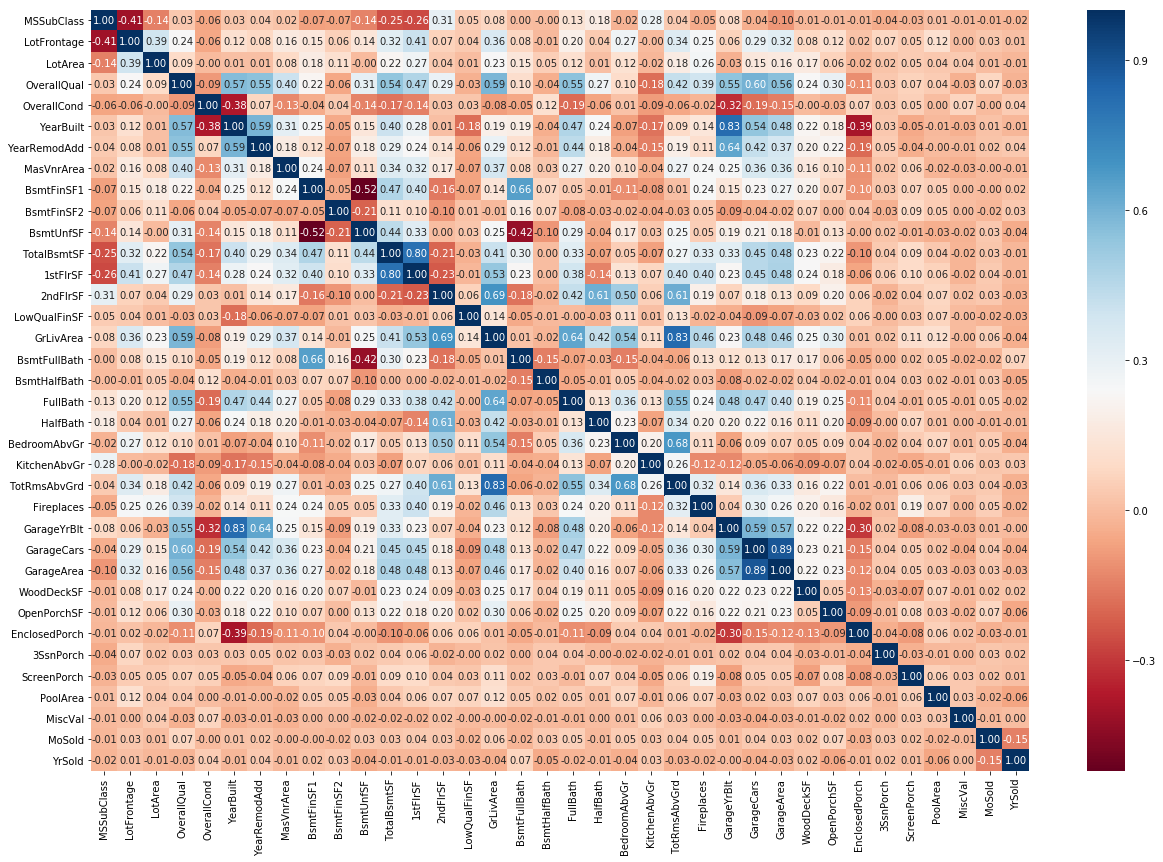

In [10]:
#Data Visualization



'''
plt.figure(1)
sns.distplot(data['LotArea'], kde = False, fit = stats.johnsonsu)
plt.figure(2)
sns.distplot(data['LotArea'], kde = False, fit = stats.norm)
plt.figure(3)
sns.distplot(data['LotArea'], kde = False, fit = stats.lognorm)
'''


In [7]:
#Using Random Forets to predict house price
from sklearn.ensemble import RandomForestClassifier
prediction_model = RandomForestClassifier()
prediction_model.fit(X_train, y_train)
predictions = prediction_model.predict(X_valid)

C:\Users\19258\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [173]:
#Normalizing data features with large skews
skew_features = data.select_dtypes(exclude = 'object').apply(lambda x: skew(x)).sort_values(ascending = False)
skew_features
high_skew = skew_features.abs() > 0.5
skew_index_1 = high_skew.index
skew_index
#data[skew_index]
#print(data[skew_index].dtypes)
#for col in skew_index:
   # data[col] = boxcox1p(data[col], boxcox_normmax(data[col + 1]))
skew_index_1

Index(['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF',
       'KitchenAbvGr', 'BsmtFinSF2', 'BsmtHalfBath', 'ScreenPorch',
       'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage',
       'SalePrice', 'WoodDeckSF', 'MSSubClass', 'BsmtUnfSF', 'GrLivArea',
       '2ndFlrSF', 'BsmtFinSF1', 'OverallCond', 'HalfBath', 'Fireplaces',
       'BsmtFullBath', 'TotalBsmtSF', 'MoSold', 'BedroomAbvGr', 'OverallQual',
       'GarageArea', 'YrSold', 'FullBath', 'Id', 'YearRemodAdd', 'YearBuilt'],
      dtype='object')